# Report template (part 1)
- Several messy notebooks make it difficult to know what information to use in the final report.
- This report collates the necessary and useful information for the final report to follow as a guide / template.

In [1]:
import nbimporter
from analysis_of_prde import run_market_session
from analysis_of_prde import pickle_obj, unpickle_obj

import matplotlib.pyplot as plt
import pandas as pd

figsize = (9, 4)

In [37]:
def plot_target_val(optimiser):
    # plot target value against iterations
    plt.figure(figsize = figsize)
    plt.plot(range(1, 1 + len(optimiser.space.target)), optimiser.space.target, "-o", markersize=4)
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.ylabel("profit per second")
    plt.show()
    
def plot_k_f(optimiser, axis=0):
    # extract data from model
    k = [round(optimiser.res[i]['params']['k']) for i, _ in enumerate(optimiser.res)]
    f = [optimiser.res[i]['params']['f'] for i, _ in enumerate(optimiser.res)]
    pps = optimiser.space.target 

    # create figure object
    fig, ax = plt.subplots(figsize=figsize)
    
    # plot pps against k, display F as variation in color
    if axis:
        scatter = ax.scatter(k, pps, c=f)
    else:
        scatter = ax.scatter(f, pps, c=k)

    # produce a legend for color variation
    ax.legend(*scatter.legend_elements(),
              bbox_to_anchor=(1.15, 1.0),
              loc="upper right", title="F" if axis else 'k')

    # cosmetic changes
    plt.grid(True)
    plt.xlabel("k" if axis else 'F')
    plt.ylabel("profit per second")
    plt.show()

def plot_bounds(optimiser, transformer, param):
    min_bound = [b[0][0] for b in transformer.bounds]
    max_bound = [b[0][1] for b in transformer.bounds]
    
    x = [optimiser.res[i]['params'][param] for i, _ in enumerate(optimiser.res)]
    iteration = list(range(explore - 1, len(x)))
    
    plt.plot(iteration, min_bound, label=f'{param} lower bound')
    plt.plot(iteration, max_bound, label=f'{param} upper bound')
    plt.plot(x[explore - 1:], label=param)
    plt.legend()

## First attempt at Bayesian optimisation
- Seems like the most sound
- Plot graphs of F and k against iteration to see if theres any convergence
- Complete statistical analysis on results of k = 4 and F > 1.9 to determine any statistical significance

In [38]:
o = unpickle_obj('optimisers/optimiser.txt')

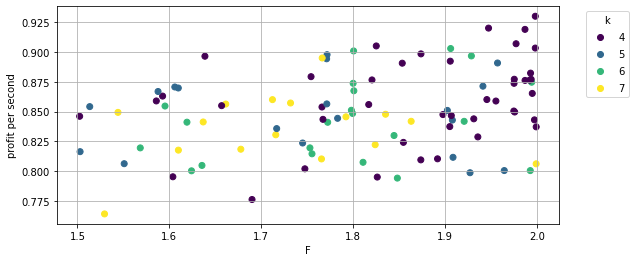

In [39]:
plot_k_f(o)

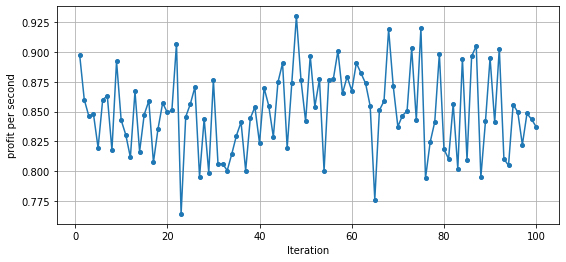

In [40]:
plot_target_val(o)

In [6]:
print(f'''--- Best params ---
F:     {round(o.max['params']['f'], 5)}
k:     {round(o.max['params']['k'], 5)}
f(x) : {round(o.max['target'], 5)}''')

--- Best params ---
F:     1.99839
k:     3.52497
f(x) : 0.92999


### Plotting k and f against iteration

In [34]:
def plot_param(data, param):
    plt.figure(figsize = figsize)
    plt.plot(range(1, 1 + len(data)), data, "-o", markersize=4)
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.ylabel(param)
    plt.show()

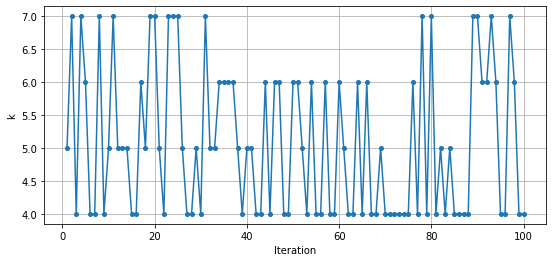

In [35]:
k = [round(o.res[i]['params']['k']) for i, _ in enumerate(o.res)]
plot_param(k, 'k')

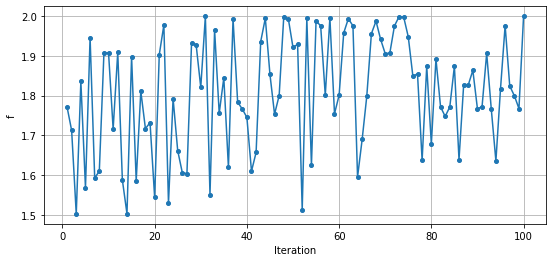

In [36]:
f = [o.res[i]['params']['f'] for i, _ in enumerate(o.res)]
plot_param(f, 'f')

Neither of the above graphs show any convincing signs of convergence throughout the simulation. In the report just use the optimal parameters produced by the optimisation process alongside the coloured scatter graph.

## Analyse the data for the optimal params

- F = 2; k = 4

- Each experiment was run with static market conditions for 2 days, with 50 simulations per experiment. Each experiment was homogeneous, only one type of trader and each trader had the same parameters. The profit per second for each trader was averaged across all simulations within the experiment to produce the line graph shown below.

In [10]:
def extract_data(params, no_traders, no_days):
    
    # unpack params
    k, f = params['k'], params['f']
    
    filename = f'prde_pps_k_{k}_f_{f}_{no_traders}_{no_days}.csv'
    df = pd.read_csv(filename)
    
    # correct slight error in the data
    df[df['t'] == 1] = 0
    
    df['t'] = df['t'] / 60/60/24
    
    # return the average results across all trials
    return df.groupby('t').mean()

In [11]:
params = [{'k': 4, 'f': 2}, {'k': 4, 'f': 0.8}]

# convert csv files into df
df_finn = extract_data(params[0], 30, 2)
df_cliff = extract_data(params[1], 30, 2)

In [12]:
print('Trader mean (Finn):', round(df_finn['actvpps'].mean(), 5))
print('Trader mean (Cliff):', round(df_cliff['actvpps'].mean(), 5))

Trader mean (Finn): 0.92836
Trader mean (Cliff): 0.80896


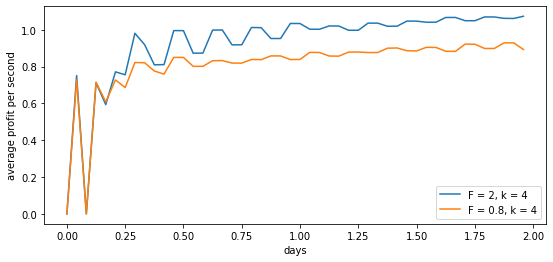

In [13]:
# plot pps against time
plt.figure(figsize = (9, 4))
df_finn['actvpps'].plot(label=f"F = {params[0]['f']}, k = 4")
df_cliff['actvpps'].plot(label=f"F = {params[1]['f']}, k = 4")
plt.xlabel('days')
plt.ylabel('average profit per second')
plt.legend(loc="best")
plt.show()

The mean for Finn's trader params is shown to be higher than that of Cliff's trader params in both the numerical value and overall in the graph. However, further analysis must be completed to determine whether this is statistically significant.

### Statistical testing
- A pairwise statistical test was required to determine whether the results were significant.
- The data was first checked for normality to determine whether to use a parametric test.
- Since the data was not normal, the non-parametric Wilcoxon test was utilised.
- The results showed that the difference in means between the two samples was statistically significant and it was concluded that Finn's trader params were more profitable than Cliff's with 95% confidence.

In [14]:
from scipy.stats import shapiro, wilcoxon

In [15]:
print('Shapiro p-value (Finn):', shapiro(df_finn['actvpps']).pvalue)
print('Shapiro p-value (Cliff):', shapiro(df_cliff['actvpps']).pvalue)

Shapiro p-value (Finn): 1.9396716177677575e-10
Shapiro p-value (Cliff): 1.6496479529615193e-11


NB: since the p-values for both sets of data are much lower than the significance level of 0.05, the null hypothesis is rejected and the datasets are not normally distributed with 95% confidence.

In [16]:
# non-parametric test
wilcoxon(df_finn['actvpps'], df_cliff['actvpps'])

/Users/finnformica/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=3.0, pvalue=4.2956093773375736e-09)